MCMC Python Notebook
====================

This notebook was designed to teach the basics of Markov-Chain-Monte-Carlo.

Topics:

I.    Introduction  
II.   Metropolis-Hasting and Gibbs sampling  
III.  Confidence Intervals and Kernel Density Estimates  
IV.   Assumptions  
V.    Convergence  
VI.   Acceptance Rates  
VII.  Dealing with Strongly Correlated Variables  
VIII. Putting it all together  
IX.   References  

# I. Introduction

Bayes Theorem:  

$$p(x~|~d) = \frac{p(x)~p(d~|~x)}{p(d)}$$

With:  

$x$ - model parameters  
$d$ - data  
$p(x~|~d) = \mathcal{P}$ - posterior  
$p(x) = \pi$ - prior  
$p(d~|~x) = \mathcal{L}$ - likelihood  
$p(d) = \mathcal{Z}$ - evidence  

The evidence, $\mathcal{Z}$, is important for Baysian model comparison.  For MCMC we are only interested in the posterior, $\mathcal{P}$, so we ignore the normalization.  We can get away without normalization as MCMC does relative comparisions of the $\mathcal{P}$ for different values of $x$.  Thus we have,

$$ \mathcal{P} \propto \pi~ \mathcal{L} $$

Let's adopt a likelihood function that uses independent Gaussians as uncertainties:

$$\mathcal{L} = \prod_k \frac{1}{(2\pi)^{1/2} \sigma_k} exp\left[-\frac{1}{2}\frac{(f(x_k)-d_k)^2}{\sigma_k^2} \right] $$

or as a log,

$$ \log\mathcal{L} = \frac{1}{2}\sum_k -\log(2 \pi) -\log(\sigma_k^2) -\frac{(f(x_k)-d_k)^2}{\sigma_k^2} $$
$$ \left( Notice: \log\mathcal{L} = -\frac{1}{2}\chi^2 + C \right) $$

With:

$f$ - our model that depends on $x$  
$\sigma$ - independent measurement error  

We did not need to assume independent Gaussian errors, but let's keep this tutorial simple.

We will adopt a Gaussian as our function:

$$ f(x) = a~exp \left[ \frac{-(x-b)^2}{2~c^2} \right] + z$$

We will consider and implement uniform priors.



In [1]:
#import modules and enable inline plots
import numpy as np
from scipy import stats #For Kernel Density Estimation
import matplotlib  #ploting
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Define our model f(x) 

In [2]:
def gaussian(x,pars):
    "Gaussian Function a=amp,b=center,c=width,z=zeropoint"
    a=pars[0];b=pars[1];c=pars[2];z=pars[3]         
    npt=len(x)
    g=np.zeros(npt)                                                #initialize output
    for i in range(0,npt):
        g[i]=(a*np.exp(-np.power(x[i]-b,2.0)/(2.0*c*c))+z) #Gaussian Function
    return g;

## Generating some fake data with Gaussian scatter

In [3]:
t=np.array(range(0,100))*0.1         #our independent variable, with 100 samples 

a=1.0;b=5.0;c=1.0;z=0.0;             #parameters for a our Gaussian model.
inputpars=np.array([a,b,c,z])

g=gaussian(t,inputpars)              #generate a Gaussian for each t

sig=0.2                              #How much noise to add

d=g+np.random.randn(len(g))*sig
#d=g+np.random.normal(0.0,sig,len(g)) #add in some Gaussian Noise
                                     #The array d now defines our data set (measurements)

#We purposely underestimate the measurement uncertainty 
uncertainty=0.1                      #assign a value to our measurement uncertainity.  
derr=np.ones(len(d))*uncertainty     #assign uncertainties to our data

## Plot our fake data

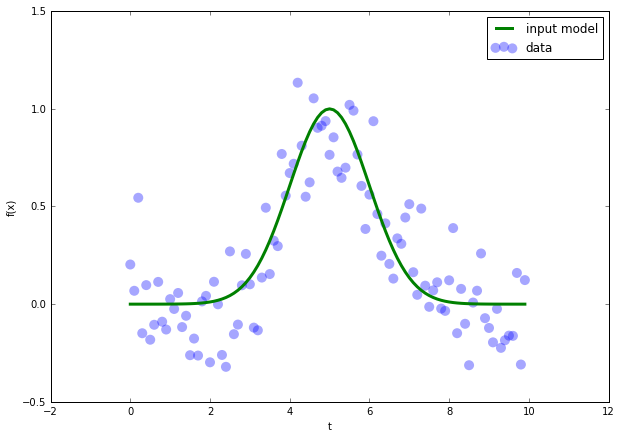

In [4]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
plt.plot(t,g,c='green',lw=3,label='input model')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.35, edgecolors="none",label='data')
plt.legend()
plt.show()

## Estimate the posterior, $\mathcal{P}$, on model parameters $x={a,b,c,z}$ given our data $d$

We will be using Markov-Chain-Monte-Carlo, first we define our Likeihood function

In [5]:
def gloglikelihood(func,pars,t,data,derr):
    "Returns the log-likelihood for independent Gaussians"
    if len(pars) > 4:
        dscale=pars[4]
    else:
        dscale=1.0
    m=func(t,pars) #get model
    n=len(data)
    if n < 1:
        ll=-1.0e30  #set bad value for no data.
    else:
        ll=-0.5*(n*np.log(2*np.pi)+sum(np.log(derr*derr*dscale*dscale))\
         +sum((m-data)*(m-data)/(derr*derr*dscale*dscale)))
    
    return ll;

and we define our Priors:

In [6]:
def glprior(pars):
    "Simple prior with log(pr)=0 with valid parameters, otherwise return large small value"
    if len(pars) > 4:
        dscale=pars[4]
    else:
        dscale=1.0
        
    badlpr=-1.0e30    #bad lpr value
    lpr=0.0           #default return value
    
    if pars[0] > 5:
        lpr=badlpr
    if pars[0] < -5:
        lpr=badlpr
    if pars[1] > 10:
        lpr=badlpr
    if pars[1] < 0:
        lpr=badlpr
    if pars[2] > 10:
        lpr=badlpr
    if pars[2] < 0:
        lpr=badlpr
    if pars[3] > 5:
        lpr=badlpr
    if pars[3] < -5:
        lpr=badlpr
    if dscale < 0:
        lpr=badlpr
    if dscale > 10:
        lpr=badlpr
    
    return lpr;

# II. Metropolis-Hastings Algorithm, and the Gibbs Sampler

Excerpts from From Ford, E. 2005 AJ 129, 1706:

> Bayesian inference using Markov chain Monte Carlo (MCMC) simulations provides a method for estimating the uncertainty of fitted parameters.  

In the next section f(x) refers to the posterior distribution $p(x~|~d)$

>The goal of the MCMC method is to generate a chain (i.e., sequence) of states (i.e., sets of parameter values $x_i$) that are sampled from a desired probability distribution [$f(x)$]. Such a chain can be calculated by specifying an initial set of parameter values, $x_0$, and a transition probability, $p(x_{n+1}|x_n)$. The Monte Carlo aspect of MCMC simulation refers to randomness in the generation of each subsequent state. The Markov property specifies that the probability distribution for determination of $x_{n+1}$ can depend on xn but not previous states. If the Markov chain is reversible, that is, if 

> $$ f(x)p(x~|~x') = f(x')p(x'~|~x) $$

>and it is aperiodic and irreducible, then it can be proved that the Markov chain will eventually converge to the stationary distribution $f(x)$ (Gilks et al. 1995). The requirement that the chain be irreducible guarantees that it will be possible for the chain to reach every state with nonzero probability from any initial state.

A Markov-Chain refers to sets of model parameters which are generated by selecting a trail parameter set and using the relative probabilities to randomly select or reject the trail set.  To show this works we will use the Metropolis-Hasting (M-H) algorithm and walk through the algorthim.

(adopted from Ford 2005) :  
 1) Initilize the chain with $n=1$, $x_n=x_0$ (current state)  
 2) Generate a trial state ($x'$) with an appropriate transition function $q(x'~|~x_n)$  
 3) Calculate the Likelihood for the trial and Likelihood for the transition state  
 4) Determine the acceptance probability $\alpha(x'|x)$  
 5) Draw a random number $u$=[0,1]  
 6) If $u \leq \alpha(x'~|~x)$ then $x_{n+1} = x'$ else $x_{n+1} = x_n$  
 7) n=n+1  
 8) GOTO step 2  
 
The acceptance probability for the M-H algorithm is,

$$ \alpha(x'~|~x) = min\left[ \frac{p(x'~|~d)~q(x~|~x')}{p(x~|~d)~q(x'~|~x)},~1   \right]$$

We will use a Gibbs sampler as our choice for $q(x~|~x')$,

$$ q(x'_{\mu}|x_{\mu}) = \frac{1}{\sqrt{2\pi\beta^2_{\mu}}} exp \left[ -\frac{(x'_{\mu}-x_{\mu})^2}{2\beta^2_{\mu}} \right] $$

Rather than trying to alter all components of $x$ and estimating the transition probabilities $q$ over a multi-dimensional space, the Gibbs sampler operations on one variable at a time.  The adoption of a Gaussian as our transition function means that $q(x'~|~x)=q(x~|~x)$ which reduces the M-H acceptance probability to,

$$ \alpha(x'~|~x) = min\left[ \frac{p(x'~|~d)}{p(x ~|~d)},~1   \right]$$.

In step(2) from our M-H recipe we now randomly select one component of $x$ to change at a time.  The Gibbs sample has tunable parameters $\beta_{\mu}$ for each parameter.  The choice of $\beta$ determines much to change a parameter value in each new state.  If $\beta$ is too large, then acceptance of new states will be low.  If $\beta$ is too small then acceptance will be too high.  In both cases, the M-H algorithm will be very slow towards reaching convergence and estimating $p(x~|~d)$.  

## Let's implement the M-H algorithm with a Gibb's sampler (M-H-G algorithm).

In [7]:
def mhgmcmc(x,llx,beta,t,d,derr,func,buffer,corbeta):
    "A Metropolis-Hastings MCMC with Gibbs sampler"
    
    xt=np.copy(x)                            #make a copy of our current state to the trail state
    npars=len(x)                             #number of parameters
    n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
    xt[n]+=np.random.normal(0.0,beta[n])     #Step 2: Generate trial state with Gibbs sampler 
    
    llxt=loglikelihood(func,xt,t,d,derr)     #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    llxt+=lprior(xt) 
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                            #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                            #Set ac to mark rejectance
        
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

## Let's use our M-H MCMC algorithm and generate 50 000 chains.

In [8]:
def genchain(x,t,d,derr,beta,niter,func,mcmcfunc,buffer=[],corbeta=1): 
    "Generate Markov Chain"
    chain=[]                                  #Initialize list to hold chain values
    accept=[]                                 #Track our acceptance rate
    chain.append(x)                           #Step 1: start the chain
    accept.append((0,0))
    llx=loglikelihood(func,x,t,d,derr)    #pre-compute the log-likelihood for Step 3
    llx=llx+lprior(x)                         #Don't forget your priors!
    
    for i in range(0,niter):
        x,llx,ac = mcmcfunc(x,llx,beta,t,d,derr,func,buffer,corbeta)
        chain.append(x)
        accept.append(ac)
        
    chain=np.array(chain)                     #Convert list to array
    accept=np.array(accept)
    
    return chain, accept;

In [9]:
loglikelihood=gloglikelihood; lprior=glprior #set which likelihood and prior we want
beta=[0.2,0.2,0.2,0.2]                    #our choice of beta for the Gibb's sampler. 
x=[0.8,4.0,0.2,0.5]                       #Step 1: initialize state 
niter=50000                               #number of iterations
chain,accept=genchain(x,t,d,derr,beta,niter,gaussian,mhgmcmc)

## Examining the MCMC output  

Let's start by looking at the first 500 chains.

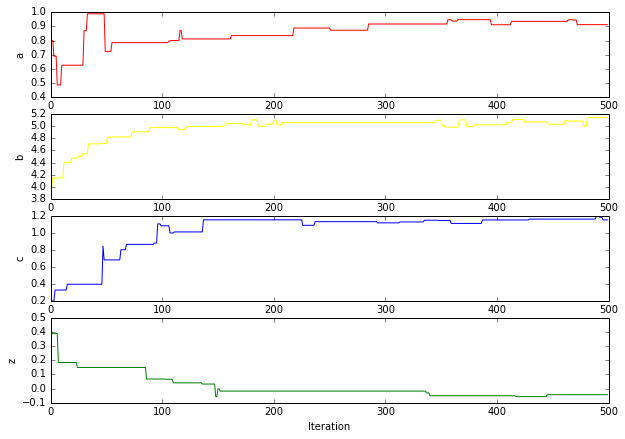

In [10]:
plt.figure(figsize=(10,7))              #adjust size of figure

plt.subplot(4, 1, 1)      
plt.plot(chain[:500,0],c='r')           #plot parameter a
plt.ylabel('a')                         #y-label

plt.subplot(4, 1, 2)
plt.plot(chain[:500,1],c='yellow')      #plot parameter b
plt.ylabel('b')                         #y-label

plt.subplot(4, 1, 3)
plt.plot(chain[:500,2],c='b')           #plot parameter c
plt.ylabel('c')                         #y-label

plt.subplot(4, 1, 4)
plt.plot(chain[:500,3],c='g')           #plot parameter z
plt.xlabel('Iteration')                 #x-label
plt.ylabel('z')                         #y-label

plt.show()

The initial values used to initiate the MCMC routine were fairly far from their optimum spot, but after about 50-75 iterations, the value for each parameter settles towards the expected values of a=1,b=5,c=1.  This initial settling is known as **burn in**.  There are various techniques for identifying burning, including visual inspection.  For now lets clip out the first 200 chains.

For general usage, I recommend to use starting values are within 1-sigma of the local minimum.  While MCMC can be used to search for the general locations of local minima MCMC is not be used for finding 'best-fits'.  MCMC is best suited for determining posterior distributions.  

In [11]:
burnin=200  #set parameter 'burnin'

Let's look at the remaining distributions. Creating a simple function that plots the contents of the chains for examination.

In [12]:
def plotchains(chain,label,colour,burnin):
    plt.figure(figsize=(12,9)) #adjust size of figure

    npar=len(chain[0,:])
    for i in range(0,npar):
        plt.subplot(npar, 1, i+1)      
        plt.plot(chain[burnin:,i],c=colour[i])  #plot parameter a
        plt.ylabel(label[i])                   #y-label

    plt.xlabel('Iteration')           #x-label

    plt.show()

When examining the chains we want to see good mixture and minimal correlation. The chains should look like random scatter.  The chains below show this behaviour.  When we deal with correlated variables we will see clear example of poor chains.

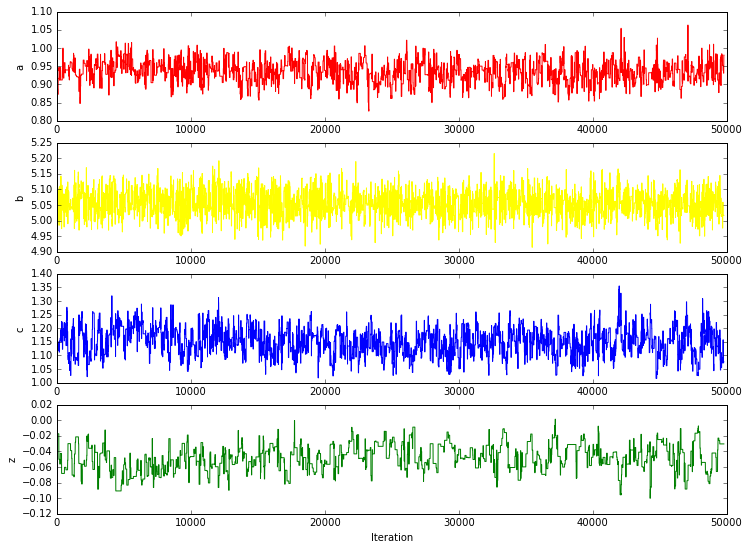

In [13]:
label=['a','b','c','z']        # Labels for the plots
colour=['r','yellow','b','g']  # Set colours
plotchains(chain,label,colour,burnin)

# III. Confidence Intervals and Kernel Density Estimates

## Means and Standard Deviation

With a Markov-Chain we can easily derive quantities related to the posterior for each parameter.  For example, estimating the mean and standard deviation for each parameter.

We can also compare how close our posteriors are to representing our input model.  A requirement of MCMC is that we understand our measurement errors.  We will revisit this topic in the next section.

In [14]:
print('  mean  stdev  inputvalue  diff-sig')
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars): #loop over all parameters
    mm[i]=np.mean(chain[burnin:,i])
    stdev=np.std(chain[burnin:,i])
    print('%s %.3f %.3f    %.3f     %.3f' % (label[i], mm[i],stdev,inputpars[i],(inputpars[i]-mm[i])/stdev))

  mean  stdev  inputvalue  diff-sig
a 0.935 0.030    1.000     2.175
b 5.056 0.039    5.000     -1.428
c 1.152 0.049    1.000     -3.063
z -0.048 0.017    0.000     2.841


The chains can be used to estimate estimate confidence limits on our measurements, for example the 5th, 50th and 95th percentile: 

In [15]:
perc = np.percentile(chain[burnin:,0],[5.0, 50.0, 95.0])
print('%s %.3f %.3f %.3f' % ('5th, 50th, 95th percentile for a:',perc[0],perc[1],perc[2]))

for i in range(0,len(chain[1,:])):
    perc = np.percentile(chain[burnin:,i],[5.0, 50.0, 95.0])
    print('%s = %.3f +%.3f %.3f (2 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

5th, 50th, 95th percentile for a: 0.885 0.937 0.984
a = 0.937 +0.047 -0.052 (2 Sigma)
b = 5.055 +0.068 -0.062 (2 Sigma)
c = 1.152 +0.079 -0.083 (2 Sigma)
z = -0.048 +0.028 -0.029 (2 Sigma)


### Kernel Density Estimates

Kernel density estimates are a method to approximate the probability density function (PDF) of our Markov-Chains in a non-parametric way.  It can be very useful to have a functional form of the posterior probability and an alternative to using histograms.

Below we compute the KDE and overlay it on the histogram of our chain values.

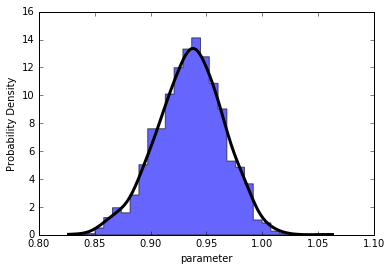

In [16]:
jpar=0 #Let's look at the first parameter

minx=np.min(chain[burnin:,jpar]) #range of parameter
maxx=np.max(chain[burnin:,jpar])

x_eval = np.linspace(minx, maxx, num=100) #make a uniform sample across the parameter range

kde1 = stats.gaussian_kde(chain[burnin:,jpar],0.3) #Kernel Density Estimate

#plot the histogram
plt.hist(chain[burnin:,jpar],30,histtype='stepfilled', normed=True, facecolor='b', alpha=0.6)

#overlay the KDE
plt.plot(x_eval, kde1(x_eval), 'k-', lw=3)

plt.xlabel('parameter')
plt.ylabel('Probability Density')
plt.show()

We can use the KDE to estimate the mode of the posterior distribution.

In [17]:
def modekdestimate(jpar,chain,burnin):

    #range of data
    minx=np.min(chain[burnin:,jpar])
    maxx=np.max(chain[burnin:,jpar])
    x_eval = np.linspace(minx, maxx, num=100)
    kde1 = stats.gaussian_kde(chain[burnin:,jpar],0.3)
    modeval=[]
    modekde=0
    for x in x_eval:
        if kde1(x) > modekde:
            modekde=kde1(x)
            modeval=x
    return modeval ;

In [18]:
print("parameter  mode")
for i in range(0,len(chain[0,:])):
    print('%8s   %.3f' % (label[i],modekdestimate(i,chain,200)))

parameter  mode
       a   0.939
       b   5.051
       c   1.150
       z   -0.047


Thus, it is trivial to estimate and report non-Gaussian and assymetric probabilities as well as generating good approximations of the posterior probability density function.  

## Examining the chain models

Each element of a Markov-Chain is a self-consistent model.  Let's plot some of the chain elements on top of our data.

In [19]:
def plotmodels(t,d,g,chain,mm,func):
    "Plot the original model, some chains and the mean model"
    plt.figure(figsize=(10,7)) #adjust size of figure
    plt.xlabel('t')            #x-label
    plt.ylabel('f(x)')         #y-label
    #plt.plot(t,g,c='red')      
    plt.scatter(t,d,c='blue', s=100.0, alpha=0.8, edgecolors="none", label='data')  #plot our data
    chainlen=len(chain[:,0])   #number of chains
    for i in range(0,200):     #plot 200 random chain elements
        nchain=int(np.random.rand()*(chainlen-burnin)+burnin)  #randomly select a chain element that is not burnin
        pars=chain[nchain,:]                   #select chain
        plotdata=func(t,pars) #return MC-model with chain element parameters
        plt.plot(t,plotdata,c='r', alpha=0.05)                       #plot the MC-model.
    plotdata=func(t,mm)
    plt.plot(t,plotdata,c='r', alpha=1.0, lw=3, label='mean MC model')
    plt.plot(t,g,c='green',lw=3, label='input model')
    plt.legend()
    plt.show()

In the plot below, the green line represents our input model  The cloud of red lines shows a sample of models extracted from the Markov-Chain.  The red line is a good representation of the data, but is not a good representation of the input model.  As alluded to earlier, the output of MCMC is based on comparisons of probabilities for different sets of model parameters.  The model probability depends on our measurement error.  You can try setting `sig` in the data generation section to different values and observe how behaviour of the Markov-Chain changes.

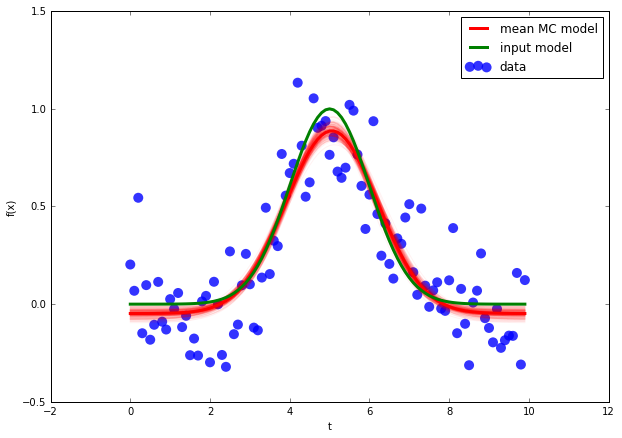

In [20]:
plotmodels(t,d,g,chain,mm,gaussian)

## Making a Triangle Plot

A triangle plot shows a histogram and KDE for each parameter in the Markov-Chain as well as scatter plots of the parameters versus each other.  The triangle plot is a very useful diagnostic to understand correlations between model parameters and the shape and distrition of posterior probabilities.

In [21]:
def triplot(chain,burnin,label,colour,nbin,ntick=5):
    "Making a Triangle Plot"

    nullfmt = NullFormatter()       # removing tick labels
    deffmt = ScalarFormatter()      # adding tick labels
    n=len(chain[1,:])               # determine number of subplots
    plt.figure(1, figsize=(10, 10))   # make a square figure
    wsize=0.9/n                     # size of individual panels

    prange=np.zeros(shape=(n,2))    #store range of parameters in chains 
    for i in range(0,n):
        prange[i,0]=min(chain[burnin:,i]) #find minimum values
        prange[i,1]=max(chain[burnin:,i]) #find maximum values

    for j in range(0,n):        #loop over each variable
        for i in range(j,n):    #loop again over each variable 
            left, width = 0.1+j*wsize, wsize        #determine panel size: left position and width
            bottom, height = 0.9-i*wsize, wsize     #determine panel size: bottom position and width
            rect_scatter = [left, bottom, width, height]#save panel size position    
            axScatter = plt.axes(rect_scatter)          #set panel size
        
            #put histogram on diagonals, scatter plot otherwise 
            if i == j:
                
                plt.hist(chain[burnin:,j],nbin,histtype='stepfilled', normed=True, \
                 facecolor=colour[i], alpha=0.8)
                
                #make a uniform sample across the parameter range
                x_eval = np.linspace(prange[j,0], prange[j,1], num=100) 
                kde1 = stats.gaussian_kde(chain[burnin:,j],0.3) #Kernel Density Estimate
                #overlay the KDE
                plt.plot(x_eval, kde1(x_eval), 'k-', lw=3)
                
                x1,x2,y1,y2 = plt.axis()                 
                plt.axis((prange[j,0],prange[j,1],y1,y2))
            else:
                axScatter.scatter(chain[burnin:,j],chain[burnin:,i],c="black", s=1.0, alpha=0.1, \
                 edgecolors="none")
                plt.axis((prange[j,0],prange[j,1],prange[i,0],prange[i,1]))   
            
            #to use a sensible x-tick range, we have to do it manually.
            dpr=(prange[j,1]-prange[j,0])/ntick         #make ntick ticks
            rr=np.power(10.0,np.floor(np.log10(dpr)))
            npr=np.floor(dpr/rr+0.5)*rr
            plt.xticks(np.arange(np.floor(prange[j,0]/rr)*rr+npr, \
             np.floor(prange[j,1]/rr)*rr,npr),rotation=30) #make ticks
        
            if i != j:    
                #use a sensible y-tick range, we have to do it manually
                dpr=(prange[i,1]-prange[i,0])/ntick         #make ntick ticks
                rr=np.power(10.0,np.floor(np.log10(dpr)))
                npr=np.floor(dpr/rr+0.5)*rr
                plt.yticks(np.arange(np.floor(prange[i,0]/rr)*rr+npr,\
                 np.floor(prange[i,1]/rr)*rr,npr),rotation=0) #make ticks
        
            axScatter.xaxis.set_major_formatter(nullfmt)  #default is to leave off tick mark labels
            axScatter.yaxis.set_major_formatter(nullfmt)
        
            #if we are on the sides, add tick and axes labels
            if i==n-1:
                axScatter.xaxis.set_major_formatter(deffmt)
                plt.xlabel(label[j]) 
            if j==0 :
                if i > 0:
                    axScatter.yaxis.set_major_formatter(deffmt)
                    plt.ylabel(label[i]) 


    plt.show()
    
    return;

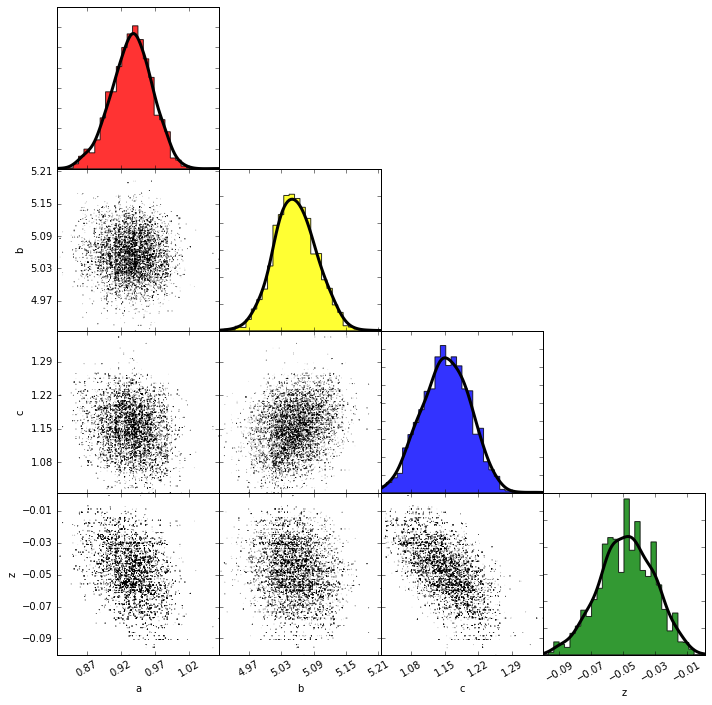

In [22]:
nbin=30                        # Number of bins for histogram
triplot(chain,burnin,label,colour,nbin)

The histograms for each parameter have a roughly Gaussian shape.  This is expected for uncorrelated parameters and Gaussian measurement uncertainties.  Some anti-correlation between parameter `z`, the zero point, and parameter `c`, the width, is observed, but it is not a problem.

# IV. Assumptions

The biggest assumption we made in our analysis, was perfect knownledge of the measurement uncertainty $\sigma$.  We can lighten this restriction by allowing for a scale-factor to be fit simultaneously with the data.  Be aware, that adding this complexity to our model assumes that we can explain differences between the model and data by rescaling our measurement errors.  In our example we know that the model is a perfect representation of the data.  In reality this is almost never true.

We are now adding a new parameter to our model, `sigscale` and generating a new set of chains.

In [23]:
x=[0.8,4.0,0.2,0.5,1.0]         #Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]      #adding a scale factor for the errors 
niter=50000                     #number of iterations
chain,accept=genchain(x,t,d,derr,beta,niter,gaussian,mhgmcmc) #generate MC
burnin=200                      #set burnin

Overlaying models from the Markov-Chain compared to our data and input model now shows much better agreement.  

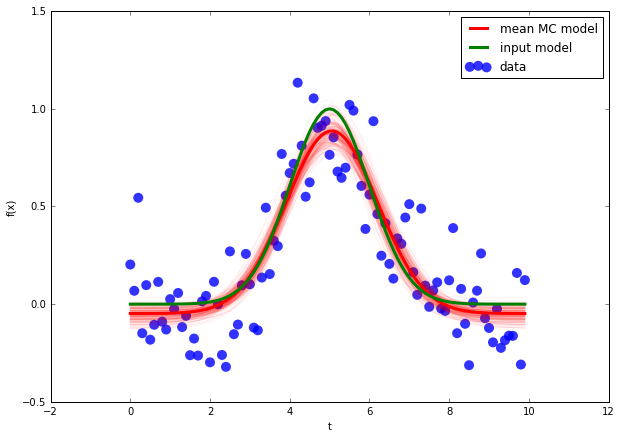

In [24]:
plotmodels(t,d,g,chain,mm,gaussian)

Better agreement from examination of the mean and standard deviation

In [25]:
label=['a','b','c','z','sigscale']        # Labels for the plots
print('          mean  stdev  inputvalue  diff-sig')
inputpars=np.append(inputpars,1.0)
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars): #loop over all parameters
    mm[i]=np.mean(chain[burnin:,i])
    stdev=np.std(chain[burnin:,i])
    print('%8s  %.3f %.3f    %.3f     %.3f' % (label[i], mm[i],stdev,inputpars[i],(inputpars[i]-mm[i])/stdev))

          mean  stdev  inputvalue  diff-sig
       a  0.935 0.058    1.000     1.115
       b  5.054 0.075    5.000     -0.713
       c  1.160 0.096    1.000     -1.667
       z  -0.050 0.032    0.000     1.568
sigscale  1.923 0.143    1.000     -6.437


The triangle plot also shows good behaviour.

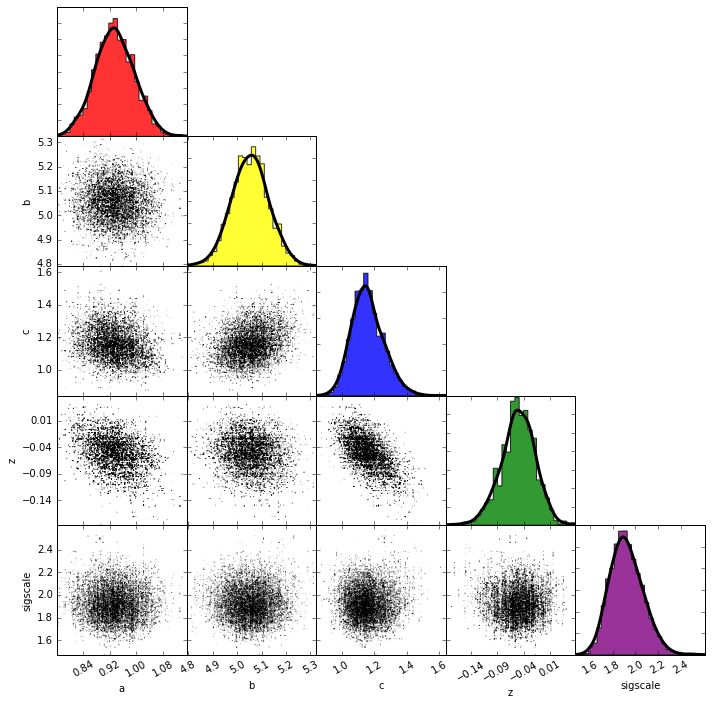

In [26]:
label=['a','b','c','z','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','purple']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,burnin,label,colour,nbin,ntick=5)

With our new Markov-Chain we can calculate the means, standard deviation and compare to our input model parameters. The standard-deviation has increased for all parameters.  All parameters values are now within 1-sigma, except that our scaling parameter that tells us that our assumed data uncertainties were too small.

# V. Convergence

We have assumed that the MCMC results have converged based on a visual inspection of the Markov-Chains and qualative assessment of the behaviour.  If the chains have converged we chain confidence that the chains are giving us a realistic representation of the posterior, $p(x~|~d)$.  A common test for convergence is to use the Gelman-Rubin Convergence criteria, which compares the in-between and within chain variance.  The test requires multiple, $M$, chains each of length, $N$.  If you only have a single chain, you can divide the chain into continuous segments, with the understanding that you are testing convergence for a chain of shorter length.

Each parameter, $\theta$ in each chain, $m$, has a mean, $\hat{\theta}_m$, and variance ,$\hat{\sigma}_m^2$.  The overal posterior mean is given by,

$$ \hat{\theta} = \frac{1}{M} \sum_{m=1}^{M} \hat{\sigma}_m^2 $$

and the between chains variance,

$$ B = \frac{N}{M-1}\sum_{m=1}^{M}(\hat{\theta}_m - \hat{\theta})^2 $$

and the within chain variance,

$$ W = \frac{1}{M} \sum_{m=1}^{M} \hat{\sigma}^2_m $$

The gives the Pooled variance,

$$  \hat{V} = \frac{N-1}{N} W + \frac{M+1}{MN} B $$

Which allows to estimate the potential scale reduction factor (PSRF),

$$ Rc = \sqrt{\frac{\hat{d}+3}{\hat{d}+1} \frac{\hat{V}}{W} } $$

with $\hat{d}$ the degrees of freedom of a t distribution. 

If $Rc$ is large, then your chains have not convergence.  One solution is to generate longer chain sets and test again.  If $Rc$ < 1.2 then your chains have likely converged.  A more stringent condition is when $Rc$ < 1.1.   


## Implement the Gelman-Rubin convergence test

In [27]:
def gelmanrubin(*chain,burnin,npt):
    "Estimating PSRF"
    M=len(chain)         #number of chains
    N=chain[0].shape[0]-burnin #assuming all chains have the same size.
    npars=chain[0].shape[1] #number of parameters
    pmean=np.zeros(shape=(M,npars)) #allocate array to hold mean calculations 
    pvar=np.zeros(shape=(M,npars))  #allocate array to hold variance calculations

    
    for i in range(0,M):
        currentchain=chain[i]
        for j in range(0,npars):
            pmean[i,j]=np.mean(currentchain[burnin:,j]) #Generate means for each parameter in each chain
            pvar[i,j]=np.var(currentchain[burnin:,j])   #Generate variance for each parameter in each chain
    
    posteriormean=np.zeros(npars) #allocate array for posterior means
    for j in range(0,npars):
        posteriormean[j]=np.mean(pmean[:,j]) #calculate posterior mean for each parameter
        
    #Calculate between chains variance
    B=np.zeros(npars)
    for j in range(0,npars):
        for i in range(0,M):
            B[j]+=np.power((pmean[i,j]-posteriormean[j]),2)
    B=B*N/(M-1.0)    
    
    #Calculate within chain variance
    W=np.zeros(npars)
    for j in range(0,npars):
        for i in range(0,M):
            W[j]+=pvar[i,j]
    W=W/M 
    
    
    #Calculate the pooled variance
    V=(N-1)*W/N + (M+1)*B/(M*N)
    
    dof=npt-1 #degrees of freedom 
    Rc=np.sqrt((dof+3.0)/(dof+1.0)*V/W) #PSRF from Brooks and Gelman (1997)
    
    #Calculate Ru
    #qa=0.95
    #ru=np.sqrt((dof+3.0)/(dof+1.0)*((N-1.0)/N*W+(M+1.0)/M*qa))
    
    return Rc;

We will generate 3 more chains.  Try changing niter to see how many chains are needed for convergence.

In [28]:
x=[0.8,4.0,0.2,0.5,1.0]                #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]             #adding a scale factor for the errors 
niter=5000                             #number of iterations
chain,accept=genchain(x,t,d,derr,beta,niter,gaussian,mhgmcmc)
chain2,accept=genchain(x,t,d,derr,beta,niter,gaussian,mhgmcmc)
chain3,accept=genchain(x,t,d,derr,beta,niter,gaussian,mhgmcmc)
burnin=200   #set burn in

We Calculate Rs for each parameter in our model.  We see that the value of Rc for each parameter is less than 1.1, giving us confidence that the chains have converged. 

In [29]:
npt=len(d) #length of data set is need to get degrees of freedom
grtest=gelmanrubin(chain,chain2,chain3,burnin=burnin,npt=npt)
print('Gelman-Rubin Convergence:')
print('parameter  Rc')
for i in range(0,len(chain[1,:])):
    print('%8s  %.3f' %(label[i],grtest[i]))

Gelman-Rubin Convergence:
parameter  Rc
       a  1.010
       b  1.022
       c  1.026
       z  1.023
sigscale  1.020


# VI. Acceptance Rates

The rate at which a trail state is accepted and rejected is an important diagnostic to consider both for MCMC algorithm efficiency and whether the MCMC results can be trusted.

If the acceptance rate is too low, then the value of $\beta$ for the Gibbs sampler is likely too large.   Many trails states are being attemped that have a low probability of success.  In this scenerio the exploration of parameter space will be slow and large chain lengths will be required for convergence.

If the acceptance rate is too high, then the value of $\beta$ for the Gibbs sampler is likely too small.  Many trails are being attempted that are close by in parameter space with similar probability to the reference state.  In this scenerio, only the local parameter and probability space is adequately explored.  The true distributions for model parameters will be very slowly explored and again, large chain lengths will be required for true convergence.

An acceptance rate should ideally be between 22 and 28% for each parameter, but this range should only be treated as a guideline.  Ultimately, you want chains that fully and uniformly explore parameter space.

First we implement a short routine to calculate acceptance rates.

In [30]:
def calcacrate(accept,burnin,label):
    "Calculate Acceptance Rates"
    nchain=len(accept[burnin:,0])
    print ('%s %.3f' % ('Global Acceptance Rate:',(nchain-np.sum(accept[burnin:,0]))/nchain))

    for j in range(0,max(accept[burnin:,1])+1):
        denprop=0   #this is for deMCMC
        deacrate=0  #this is for deMCMC
        
        nprop=0   #number of proposals
        acrate=0  #acceptance rate
        
        for i in range(burnin,nchain): #scan through the chain.
            if accept[i,1] == j :
                nprop=nprop+1
                acrate=acrate+accept[i,0]
            if accept[i,1] == -1 :
                denprop=denprop+1
                deacrate=deacrate+accept[i,0]
                
        print('%s Acceptance Rate %.3f' % (label[j],(nprop-acrate)/nprop))
    
    #if we have deMCMC results, report the acceptance rate.
    if denprop > 0:
        print('%s Acceptance Rate %.3f' % ('deMCMC',(denprop-deacrate)/denprop))
        
    return;

The acceptance rates for our chains is causously too large for some parameters.  This tells us that our initial guess for $\beta$ was probably too small for many of the parameters.  

In [31]:
calcacrate(accept,burnin,label)

Global Acceptance Rate: 0.387
a Acceptance Rate 0.255
b Acceptance Rate 0.414
c Acceptance Rate 0.340
z Acceptance Rate 0.121
sigscale Acceptance Rate 0.779


## Getting a better acceptance Rate

To obtain acceptance rates that are closer to the ideal range.  We can either manually adjust $\beta$, or dynamically adjust $\beta$ using the prescription from Gregory 2001 by first estimating 

$$ acorsub = \frac{nacor - nacorsub}{npropP - npropPsub} $$

where,  
$nacor$ - total number of accepted proposals  
$nacorsub$ - total number of accepted proposals immediately prior to rescaling $\beta$  
$npropP$ - total number of proposals  
$npropPsub$ - total number of proposals imediately prior to rescaling $\beta$  

We then define our rescaling parameter, $corscale$,

$$ corscale=corscale \times \left[ \frac{acorsub+\Delta}{0.25} \times \frac{0.75}{1-acorsub+\Delta}\right]^{1/4} $$

with $\Delta=0.01$. 

If the acceptance rate is 0.25 then corscale does not change.



In [32]:
def betarescale(x,t,d,derr,beta,niter,burnin,func,mcmcfunc,imax=20):
    "Calculate rescaling of beta to improve acceptance rates"
    
    alow = 0.22  #alow, ahigh define the acceptance rate range we want
    ahigh = 0.28
    
    delta=0.01  #parameter controling how fast corscale changes - from Gregory 2011.
    
    npars=len(x)   #Number of parameters
    acorsub=np.zeros(npars) 
    nacor=np.zeros(npars)       #total number of accepted proposals
    nacorsub=np.zeros(npars)    #total number of accepted proposals immediately prior to rescaling
    npropp=np.zeros(npars)      #total number of proposals
    nproppsub=np.zeros(npars)   #total number of proposals immediately prior to rescaling
    acrate=np.zeros(npars)      #current acrate 
    corscale=np.ones(npars)
    
    #inital run
    chain,accept=genchain(x,t,d,derr,beta,niter,func,mcmcfunc) #Get a MC   
    nchain=len(chain[:,0])
    
    #calcalate initial values of npropp and nacor 
    for i in range(burnin,nchain):
        j=accept[i,1]           #get accept flag value
        npropp[j]+=1            #update total number of proposals
        nacor[j]+=1-accept[i,0] #update total number of accepted proposals
        
    #update x
    xin=chain[niter,:]  #we can continue to make chains by feeding the current state back into genchain
    
    acrate=nacor/npropp #inital acceptance rate
    
    afix=np.ones(npars)  #afix is an integer flag to indicate which beta entries need to be updated
    for i in range(0,npars):
        if acrate[i]<ahigh and acrate[i]>alow:   #we strive for an acceptance rate between alow,ahigh
            afix[i]=0    #afix=0 : update beta, afix=1 : do not update beta

    #We will iterate a maximum of imax times - avoid infinite loops
    icount=0   #counter to track iterations
    while (np.sum(afix) > 0):
        icount+=1  #track number of iterations
        
        nacorsub=np.zeros(npars)  #reset nacorsub counts for each loop
        nproppsub=np.zeros(npars) #reset nproppsub counts for each loop
        
        #Make another chain starting with xin
        betain=beta*corscale   #New beta for Gibbs sampling   
        chain,accept=genchain(xin,t,d,derr,betain,niter,func,mcmcfunc) #Get a MC
        xin=chain[niter,:]     #Store current parameter state 
        
        for i in range(burnin,nchain): #scan through Markov-Chains and count number of states and acceptances 
            j=accept[i,1]
            if acrate[j]>ahigh or acrate[j]<alow: 
                npropp[j]+=1            #update total number of proposals
                nacor[j]+=1-accept[i,0] #update total number of accepted proposals
                nproppsub[j]+=1            #Update current number of proposals
                nacorsub[j]+=1-accept[i,0] #Update current number of accepted proposals
    
        for i in range(0,npars):  #calculate acceptance rates for each parameter that is to updated 
            if afix[i]>0:
                #calcate current acrates
                acrate[i]=nacorsub[i]/nproppsub[i]
    
                #calcualte acorsub
                acorsub[i]=(nacor[i]-nacorsub[i])/(npropp[i]-nproppsub[i])
    
                #calculate corscale
                corscale[i]=corscale[i]*np.power((acorsub[i]+delta)*0.75/(0.25*(1.0-acorsub[i]+delta)) ,0.25)
    
        for i in range(0,npars):  #check which parameters have achieved required acceptance rate
            if acrate[i]<ahigh and acrate[i]>alow:
                afix[i]=0

        if(icount>imax):   #if too many iterations, then we give up and exit
            afix=np.zeros(npars)
            print("Too many iterations: icount > imax")
    
    print('Final Acceptance: ',acrate) #report acceptance rates
    
    return corscale;

Now we can get scaling parameters for better $\beta$ values.  If you get a warning about too many iterations, try repeating the calculation until all parameters have good acceptance rates or set imax to a larger number.

In [33]:
x=[0.8,4.0,0.2,0.5,1.0]                #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]             #adding a scale factor for the errors 

niter=1000   #number of chains to generate for testing acceptance rates
burnin=100   #how many of the chains are burn-in
corscale=betarescale(x,t,d,derr,beta,niter,burnin,gaussian,mhgmcmc,imax=40)
print("New beta scaling: ",corscale)
print("Recommended Beta: ",beta*corscale)

Final Acceptance:  [ 0.25945946  0.25581395  0.27956989  0.22826087  0.26415094]
New beta scaling:  [ 1.          1.88711561  1.42040409  0.44287829  8.14891372]
Recommended Beta:  [ 0.2         0.37742312  0.28408082  0.08857566  0.81489137]


# VII. Dealing with Strongly Correlated Parameters
====================================================================

In our example of fitting a Gaussian you may have noticed that parameters 'c' and 'z' were negatively correlated.  As the zero point is made larger, the amplitude must be made smaller.  Heavily correlated parameters are problematic for M-H routines with Gibbs sampling.  As only one parameter is varied, when attempting a new state, the acceptance will be much lower as the associated correlated variable is left unchanged.  The result is that our sampler will inefficiently explore parameter space.  There are a number of solutions to this problem which include:

1. using a different model parameterization
2. creating longer MCs
3. Using a different sampler.

A different parameterization is usually a good choice.  Maybe you have two parameters that are completely degenerate?  Of course it quite common that you cannot simply recast the problem.

Creating longer MCs is a brute-force method that should be avoided.  It can become very difficult to determine if you have fully explored correlated parameter space and very difficult to prove that your chains have converged. 

There is an enormous amount of research and literature on dealing with correlated parameters.  One solution is commonly known as 'de-MCMC' which uses a set of previously accepted trail states to create vectorized jumps.  This approach can very efficiently explore correlated parameter space. 

## A Correlated Model

To show how M-H-G fails with strongly correlated parameters and how deMCMC operatres, we will adopt a modified Gaussian as our function:

$$ f(x) = mag~a~exp \left[ \frac{-(mag~x-b)^2}{2~c^2~mag^2} \right] + z$$

The new parameter `mag` will certainly cause use trouble!

In [34]:
def mgaussian(x,pars):
    "Gaussian Function a=amp,b=center,c=width,z=zeropoint"
    a=pars[0];b=pars[1];c=pars[2];z=pars[3];mag=pars[4]                            
    npt=len(x)
    g=np.zeros(npt)                                                #initialize output
    for i in range(0,npt):
        g[i]=(mag*a*np.exp(-np.power(mag*x[i]-b,2.0)/(2.0*c*c*mag*mag))+z) #Gaussian Function
    return g;

## Make a new fake dataset

In [35]:
t=np.array(range(0,100))*0.1         #our independent variable, with 100 samples 

a=1.0;b=5.0;c=1.0;z=0.0;mag=1.0      #parameters for a our modified-Gaussian model.
pars=np.array([a,b,c,z,mag])

g=mgaussian(t,pars)        #generate a Gaussian for each t

sig=0.2                              #How much noise to add

d=g+np.random.normal(0.0,sig,len(g)) #add in some Gaussian Noise
                                     #The array d now defines our data set (measurements)
#We purposely underestimate the measurement uncertainty 
uncertainty=0.1                      #assign a value to our measurement uncertainity.  
derr=np.ones(len(d))*uncertainty     #assign uncertainties to our data

## The effect of the new parameter

The `mag` parameter has the effect of modulating the amplitude and the position of Gaussian.

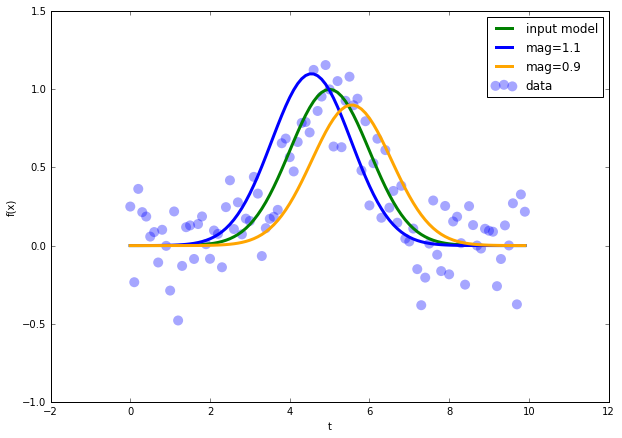

In [36]:
plt.figure(figsize=(10,7)) #adjust size of figure

plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label

plt.plot(t,g,c='green',lw=3,label='input model')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.35, edgecolors="none",label='data')

plotdata=mgaussian(t,np.array([a,b,c,z,1.1]))
plt.plot(t,plotdata,c='blue',lw=3,label='mag=1.1') 

plotdata=mgaussian(t,np.array([a,b,c,z,0.9]))
plt.plot(t,plotdata,c='orange',lw=3,label='mag=0.9')  

plt.legend()

plt.show()

## New likelihood and prior function

Any new model will need a new likelihood and prior.

In [37]:
def mloglikelihood(func,pars,t,data,derr):
    "Returns the log-likelihood for independent Gaussians"
    if len(pars) > 5:
        dscale=pars[5]
    else:
        dscale=1.0
    m=func(t,pars) #get model
    n=len(data)
    if n < 1:
        ll=-1.0e30  #set bad value for no data.
    else:
        ll=-0.5*(n*np.log(2*np.pi)+sum(np.log(derr*derr*dscale*dscale))\
         +sum((m-data)*(m-data)/(derr*derr*dscale*dscale)))
    
    
    return ll;

In [38]:
def mlprior(pars):
    "Simple prior with log(pr)=0 with valid parameters, otherwise return large small value"
    if len(pars) > 5:
        dscale=pars[5]
    else:
        dscale=1.0
        
    badlpr=-1.0e30    #bad lpr value
    lpr=0.0           #default return value
    if pars[0] > 5:
        lpr=badlpr
    if pars[0] < -5:
        lpr=badlpr
    if pars[1] > 10:
        lpr=badlpr
    if pars[1] < 0:
        lpr=badlpr
    if pars[2] > 10:
        lpr=badlpr
    if pars[2] < 0:
        lpr=badlpr
    if pars[3] > 5:
        lpr=badlpr
    if pars[3] < -5:
        lpr=badlpr
    if dscale < 0:
        lpr=badlpr
    if dscale > 10:
        lpr=badlpr
    if pars[4] > 10:
        lpr=badlpr
    if pars[4] < -10:
        lpr=badlpr
    
    return lpr;

setting the likelihood and prior to be used.

In [39]:
loglikelihood=mloglikelihood; lprior=mlprior

## Calculate $\beta$

As we have done before, we can calculate better values for $\beta$.  Do not be surprized if the maximum number of iterations is reached.  Since we are dealing with strongly correlated variables, the parameter independence we assume for Gibbs sampling breaks down.  As long as the corscale is greater than zero, we should be fine.

In [40]:
x=   [0.95,4.95,0.95,0.05,1.01,1.01]    #our initial State
beta=[0.2 ,0.2 ,0.2 ,0.2 ,0.05,0.05]    #initial guess for beta
niter=2000    #number of chains to generate for testing acceptance rates
burnin=200    #how many of the chains are burn-in
corscale=betarescale(x,t,d,derr,beta,niter,burnin,mgaussian,mhgmcmc,imax=40)  #Increased imax to ensure good corscale 
print("New beta scaling: ",corscale)
print("Recommended Beta: ",beta*corscale)

Final Acceptance:  [ 0.25581395  0.25503356  0.27184466  0.27457627  0.25249169  0.26279863]
New beta scaling:  [  1.           1.98593697   1.29422938   0.40032842   1.53554936
  23.37882028]
Recommended Beta:  [ 0.2         0.39718739  0.25884588  0.08006568  0.07677747  1.16894101]


## Calculate Chains

Now we generate a set of 3 chains with M-H-G. 

In [41]:
betanew=beta*corscale #apply our new beta
niter=50000                     #number of iterations
burnin=400
chain,accept=genchain(x,t,d,derr,betanew,niter,mgaussian,mhgmcmc)
chain2,accept=genchain(x,t,d,derr,betanew,niter,mgaussian,mhgmcmc)
chain3,accept=genchain(x,t,d,derr,betanew,niter,mgaussian,mhgmcmc)

## Examine Chains

A quick look at the chains and you can immediately see that there is strong correlation between parameters and the chains for parameters `a`, `b` and `mag` are not well mixed.  The chains are very slowly exploring parameter space.  This behaviour is a clear example of what you *do not* want to see. 

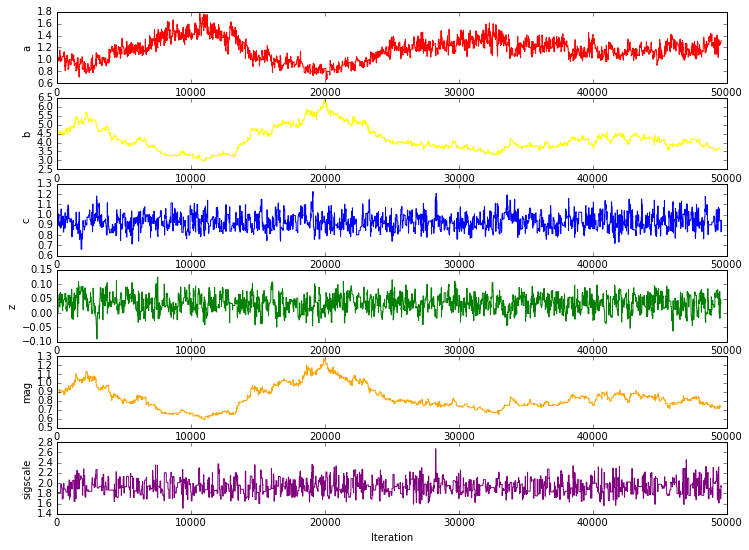

In [42]:
label=['a','b','c','z','mag','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','orange','purple']  # Set colours
plotchains(chain,label,colour,burnin)

### Convergence Tests

The Gelman-Rubin test confirms our suspicion that the chains have not converged for parameters `a`, `b` and `mag`.  

In [43]:
npt=len(d) #length of data set is need to get degrees of freedom
grtest=gelmanrubin(chain,chain2,chain3,burnin=burnin,npt=npt)
print('Gelman-Rubin Convergence:')
print('parameter  Rc')
for i in range(0,len(chain[1,:])):
    print('%8s  %.3f' %(label[i],grtest[i]))

Gelman-Rubin Convergence:
parameter  Rc
       a  1.686
       b  1.620
       c  1.010
       z  1.010
     mag  1.618
sigscale  1.011


### Compute Percentiles

Naively, the medians and associated uncertainties look reasonable, but we should not trust them.

In [44]:
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars):
    perc = np.percentile(chain[burnin:,i],[5.0, 50.0, 95.0])
    mm[i]=perc[1]
    print('%s = %.3f +%.3f %.3f (2 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

a = 1.160 +0.310 -0.320 (2 Sigma)
b = 4.025 +1.493 -0.753 (2 Sigma)
c = 0.924 +0.133 -0.109 (2 Sigma)
z = 0.033 +0.044 -0.047 (2 Sigma)
mag = 0.805 +0.297 -0.149 (2 Sigma)
sigscale = 1.918 +0.272 -0.210 (2 Sigma)


### Compare to Ground Truth

The chains themselves are a good match to the data and the input parameter.

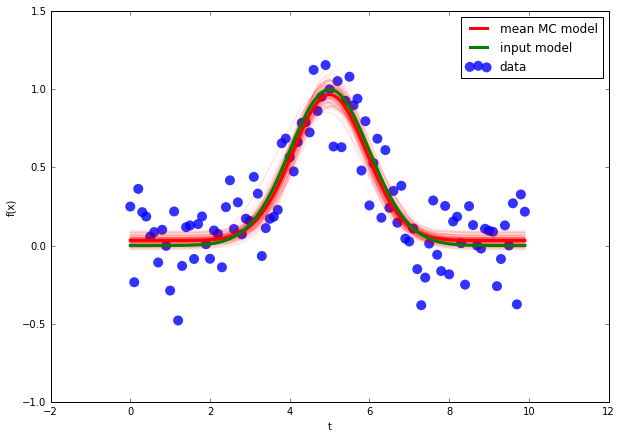

In [45]:
plotmodels(t,d,g,chain,mm,mgaussian)

### Triange Plot

Histograms and scatter plots of the chain values are also quite messy.

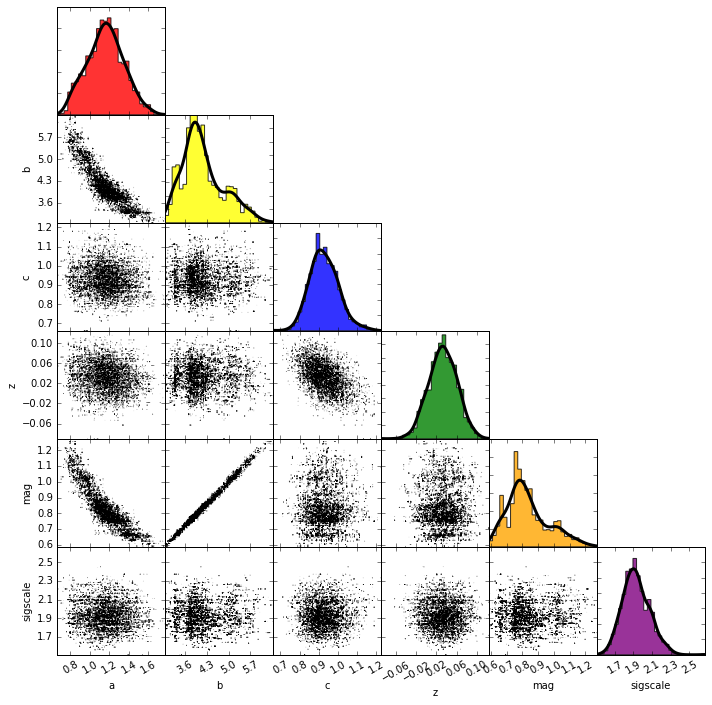

In [46]:
nbin=30                        # Number of bins for histogram
triplot(chain,burnin,label,colour,nbin,ntick=5)

## Ouch!

As you can see, our MCMC algorithm did not do a very good job with the new model.  Specifically, the Gibbs sampler is not very efficient at exploring parameter space. There are now very strong correlations between the parameters and the parameters mag and b are clearly degenerate.  When you see this type of behaviour, you can either recongnize that your model is not constrained by the data or push further to use techiques that do a better job of exploring correlated parameter space.

## De-MCMC

Our de-MCMC algorithm has a few components.  First, we need a collection of trails to sample from.  We can generate this with our M-H-Gibbs routine.

In [47]:
nbuffer=10000 #Size of our deMCMC buffer
burnin=500   #burn-in for M-H
niter=nbuffer+burnin 
chain,accept=genchain(x,t,d,derr,betanew,niter,mgaussian,mhgmcmc)
buffer=np.copy(chain[burnin:,:])

To make a new trail state with deMCMC we randomly select two entries from our buffer.  Take the difference, and apply the difference to our current state.  This produces a vectorized jump that uses the local correlations discovered by the Gibbs sampler.  deMCMC allows us to explore correlated variable space much more efficiently.  Just like the Gibbs sample, we also have a scale-factor that determines the size of our correlated jumps that is tuned to give us an good acceptance rate.

We our new state we can still use our M-H algorithm to decide whether to accept or reject the jump.  As long as the deMCMC buffer is constant, then our new routine will eventually converge.

To integrate our deMCMC sampler, we will use a hybrid approach that also uses a Gibbs sample.  The deMCMC sample is very good a exploring strong correlated parameter space but it can't turn 'corners'.  So we also use our Gibb's sample to explore the local parameter.  For each chain element we randomly select either the deMCMC or Gibbs sampler.

In [48]:
def demhmcmc(x,llx,beta,t,d,derr,func,buffer,corbeta):
    "A Metropolis-Hastings MCMC with Gibbs sampler"
    
    nbuffer=len(buffer[:,0])
    rsamp=np.random.rand() #draw a random number to decide which sampler to use
    
    if rsamp < 0.5: #if rsamp is less than 0.5 use a Gibbs sampler 

        xt=np.copy(x)                            #make a copy of our current state to the trail state
        npars=len(x)                             #number of parameters
        n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
        xt[n]=xt[n]+np.random.normal(0.0,beta[n])#Step 2: Generate trial state with Gibbs sampler 

    else:   #use our deMCMC sampler

        n=-1 #tell the accept array that we used the deMCMC sampler
        i1=int(np.random.rand()*nbuffer)
        i2=int(np.random.rand()*nbuffer)
        vectorjump=buffer[i1,:]-buffer[i2,:]
        xt=x+vectorjump*corbeta
    
    llxt=loglikelihood(func,xt,t,d,derr) #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    llxt=llxt+lprior(xt) 
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                             #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                             #Set ac to mark rejectance
        
    xp1=np.array(xp1)
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

Now we generate a set of chains with out deMCMC routine.  This new set should do a much better job of explore parameter space.

In [49]:
corbeta=1.0 #scale for correlated jumps
xin=buffer[nbuffer,:] #we can start with the last state from our buffer.
niter=50000
chain,accept=genchain(xin,t,d,derr,betanew,niter,mgaussian,demhmcmc,buffer=buffer,corbeta=corbeta)

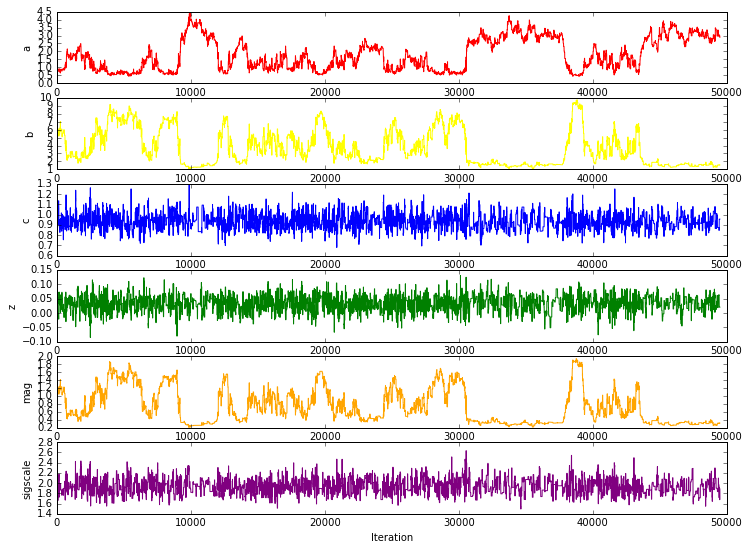

In [50]:
plotchains(chain,label,colour,burnin)

We are now doing a better job of explore parameter space, but the autocorrelation length for parameters a,b and mag are still not very good.  To fix this, we use this set of chains as the buffer for a new run.  For very complicated parameter space you can repeatly update the buffer until you are satisfied with the results.

In [51]:
buffer=np.copy(chain)
nbuffer=len(buffer[:,0])

Now we generate a 3 sets of chains with our updated buffer.

In [52]:
corbeta=0.3 #scale for correlated jumps
xin=buffer[nbuffer-1,:] #we can start with the last state from our buffer.
niter=50000
chain,accept=genchain(xin,t,d,derr,betanew,niter,mgaussian,demhmcmc,buffer=buffer,corbeta=corbeta)
chain2,accept2=genchain(xin,t,d,derr,betanew,niter,mgaussian,demhmcmc,buffer=buffer,corbeta=corbeta)
chain3,accept3=genchain(xin,t,d,derr,betanew,niter,mgaussian,demhmcmc,buffer=buffer,corbeta=corbeta)

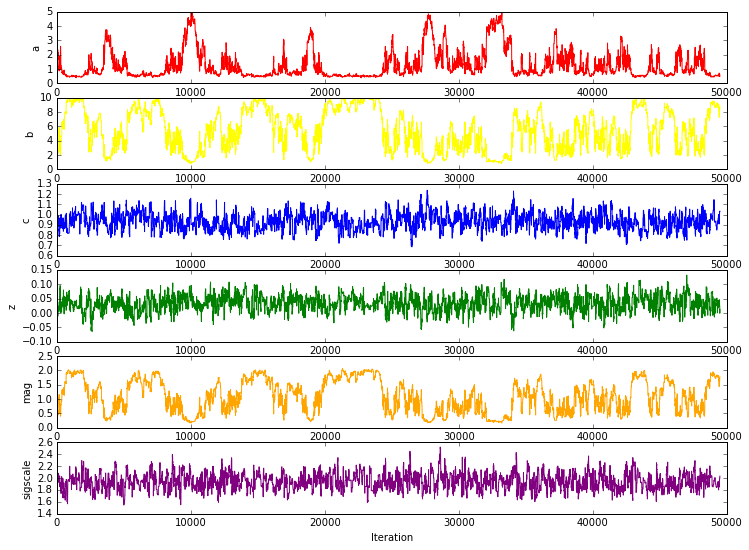

In [53]:
plotchains(chain,label,colour,burnin)

The chains are looking much better.  There are still a few sections with a somewhat long-autocorrelation, but as we shall see, we are passing convergence tests and the chain parameter distributions look reasonable.  In a real world application I would probably adjust `corbeta` to get a better acceptance rate and generate longer chains.  We can (and should) concatenate all 3 chains together to make one long-chain to use when generating our posteriors.

In [54]:
calcacrate(accept,burnin,label)

Global Acceptance Rate: 0.216
a Acceptance Rate 0.323
b Acceptance Rate 0.210
c Acceptance Rate 0.253
z Acceptance Rate 0.300
mag Acceptance Rate 0.218
sigscale Acceptance Rate 0.141
deMCMC Acceptance Rate 0.193


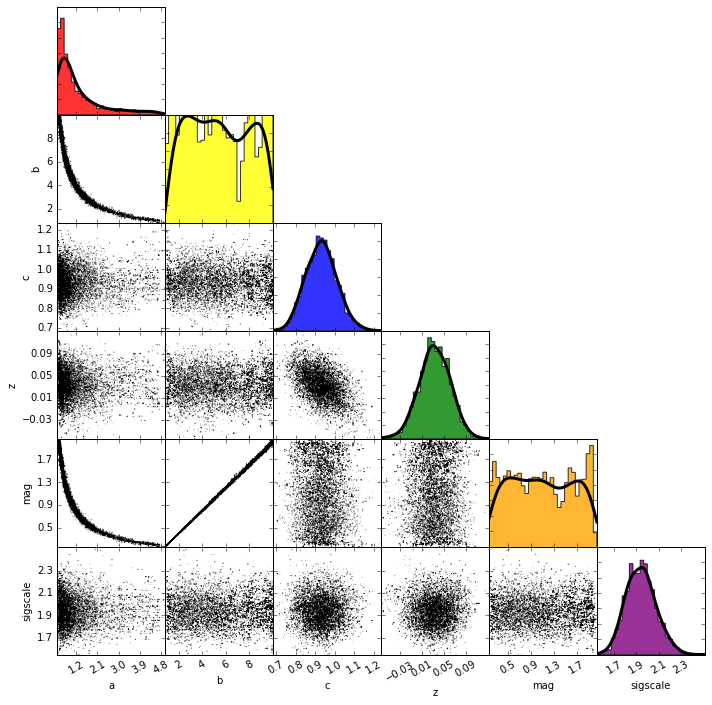

In [55]:
nbin=30                        # Number of bins for histogram
triplot(chain,burnin,label,colour,nbin,ntick=5)

We are now passing our convergence tests

In [56]:
npt=len(d) #length of data set is need to get degrees of freedom
grtest=gelmanrubin(chain,chain2,chain3,burnin=burnin,npt=npt)
print('Gelman-Rubin Convergence:')
print('parameter  Rc')
for i in range(0,len(chain[1,:])):
    print('%8s  %.3f' %(label[i],grtest[i]))

Gelman-Rubin Convergence:
parameter  Rc
       a  1.041
       b  1.039
       c  1.011
       z  1.011
     mag  1.039
sigscale  1.015


and our recovered parameters agree with ground truth within uncertainty.

In [57]:
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars):
    perc = np.percentile(chain[burnin:,i],[5.0, 50.0, 95.0])
    mm[i]=perc[1]
    print('%s = %.3f +%.3f %.3f (2 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

a = 0.870 +2.785 -0.389 (2 Sigma)
b = 5.393 +4.343 -4.120 (2 Sigma)
c = 0.931 +0.131 -0.124 (2 Sigma)
z = 0.033 +0.044 -0.046 (2 Sigma)
mag = 1.086 +0.862 -0.833 (2 Sigma)
sigscale = 1.938 +0.232 -0.205 (2 Sigma)


In this example, we can see the effect of the prior which limits the value of `b` between 0 and 10.  The MCMC output is telling us that the data gives no constaint on the correlation between parameters `b` and `mag`.

# VIII. Putting it all Together
=====================================================

## Okay you've made this far, lets put everything together for the beginning...

1. Define dataset, function, likelihood and prior
2. Estimate $\beta$  
3. Calculate Buffer
4. Run deMCMC hybrid routine
5. Re-run deMCMC with new buffer
6. Examine Chains - should we run deMCMC again? 
7. Examine Acceptance Rates  
8. Convergence Tests  
9. Calculate Median and 95% percentile  
10. Compare to Ground Truth  
11. Triangle Plot of posteriors  

## 1. Define dataset, function, likelihood and prior

### Generating some fake data with Gaussian scatter

We generate 100 samples from our model and add Gaussian noise to the samples to produce a synthetic dataset.

In [58]:
t=np.array(range(0,100))*0.1         #our independent variable, with 100 samples 

a=1.0;b=5.0;c=1.0;z=0.0;             #parameters for a our Gaussian model.
pars=np.array([a,b,c,z])

g=gaussian(t,pars)                   #generate a Gaussian for each t
sig=0.2                              #How much noise to add
d=g+np.random.normal(0.0,sig,len(g)) #add in some Gaussian Noise
                                     #The array d now defines our data set (measurements)

#We purposely underestimate the measurement uncertainty 
uncertainty=0.1                      #assign a value to our measurement uncertainity.  
derr=np.ones(len(d))*uncertainty     #assign uncertainties to our data

#Use our likelihood and priors for our Gaussian model
loglikelihood=gloglikelihood; lprior=glprior #set which likelihood and prior we want

### Plot our fake data

Our input model compared to the synthetic data.

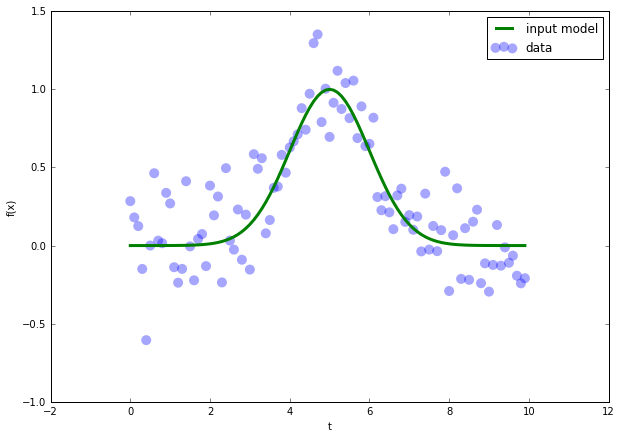

In [59]:
plt.figure(figsize=(10,7)) #adjust size of figure
plt.xlabel('t')            #x-label
plt.ylabel('f(x)')         #y-label
plt.plot(t,g,c='green',lw=3,label='input model')      
plt.scatter(t,d,c='blue', s=100.0, alpha=0.35, edgecolors="none",label='data')
plt.legend()
plt.show()

## 2. Estimate $\beta$

$\beta$ controls how far the Gibbs sampler can jump when selecting a new state.  We run a few small iterations of our M-H-G algorthim and estimate a value of $\beta$ that provides good acceptance rates.

In [60]:
x=[0.8,4.0,0.2,0.5,1.0]                #adding a guess for the scale-factor, Step 1: initialize state  
beta=[0.2,0.2,0.2,0.2,0.1]             #adding a scale factor for the errors 

niter=2000    #number of chains to generate for testing acceptance rates
burnin=200    #how many of the chains are burn-in
corscale=betarescale(x,t,d,derr,beta,niter,burnin,gaussian,mhgmcmc,imax=40)  #Increased imax to ensure good corscale 
print("New beta scaling: ",corscale)
print("Recommended Beta: ",beta*corscale)

Final Acceptance:  [ 0.22636103  0.27556818  0.24483776  0.25144509  0.26256983]
New beta scaling:  [ 1.28090308  1.58589196  1.67015903  0.53215283  6.21996132]
Recommended Beta:  [ 0.25618062  0.31717839  0.33403181  0.10643057  0.62199613]


## 3. Calculate Buffer

The buffer contains a fixed set of Markov-Chains that is used an input to the deMCMC algorithm.  Our initial buffer is populated with a chain from our M-H-G algorithm.

In [61]:
betanew=beta*corscale #apply our new beta
nbuffer=10000 #Size of our deMCMC buffer
burnin=500   #burn-in for M-H-G
niter=nbuffer+burnin 
chain,accept=genchain(x,t,d,derr,betanew,niter,gaussian,mhgmcmc)
buffer=np.copy(chain[burnin:,:])

## 4. Run deMCMC hybrid routine

The deMCMC algorithm is now run.  For heavily correlated variables it is very likely deMCMC will greatly expand parameter space that has been explored. 

We start the deMCMC routine using the last chain value from M-H-G.  This avoids any problems with burn in.  

The length of the vectorized jumps is scaled by the parameter `corbeta`.  If you have poor acceptance rates `corbeta` should be adjusted.

In [62]:
corbeta=1.0 #scale for correlated jumps
xin=buffer[nbuffer-1,:] #we can start with the last state from our buffer.
niter=50000
chain,accept=genchain(xin,t,d,derr,betanew,niter,gaussian,demhmcmc,buffer=buffer,corbeta=corbeta)

## 5. Re-run deMCMC with new buffer

We now take the chain from our first run of deMCMC and make that our buffer for a second run.  We want the buffer to be representative of all correlations in parameter space.  For very complicated posteriors you may need to iterate the generation of a buffer a few times or employ additional techniques such as *simulated annealing*.  You can also try increasing the length of the chains and buffer.

In [63]:
buffer=np.copy(chain)
nbuffer=len(buffer[:,0])
corbeta=0.5 #scale for correlated jumps
xin=buffer[nbuffer-1,:] #we can start with the last state from our buffer.
niter=50000
chain,accept=genchain(xin,t,d,derr,betanew,niter,gaussian,demhmcmc,buffer=buffer,corbeta=corbeta)
chain2,accept=genchain(xin,t,d,derr,betanew,niter,gaussian,demhmcmc,buffer=buffer,corbeta=corbeta)
chain3,accept=genchain(xin,t,d,derr,betanew,niter,gaussian,demhmcmc,buffer=buffer,corbeta=corbeta)

## 6. Examine Chains - should we run deMCMC again?

Do the chains look well mixed?  
Has parameter space been uniformly explored?

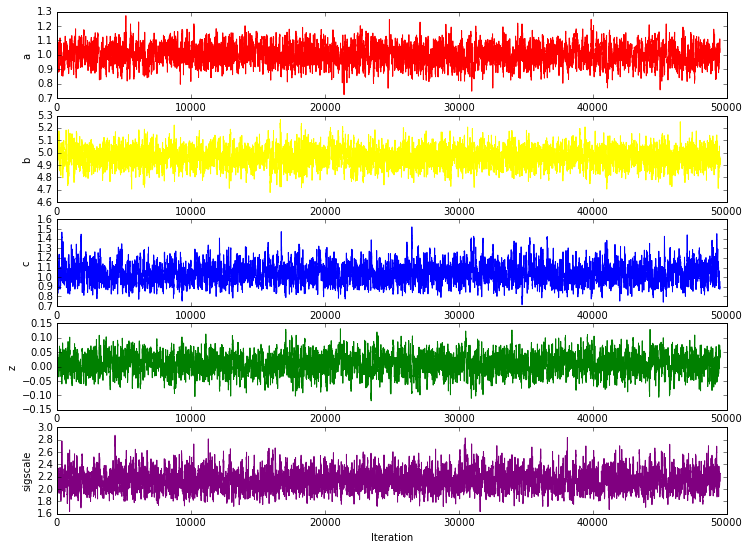

In [64]:
label=['a','b','c','z','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','purple']  # Set colours
plotchains(chain,label,colour,burnin)

## 7. Examine Acceptance Rates

You want acceptance rates close to 25%.  Very high (>50%) acceptance is a good indicator that you are not fully exploring parameter space.  Very low (5%) acceptance will mean long chains are necessary to see good mixing and convergence.

In [65]:
calcacrate(accept,burnin,label)

Global Acceptance Rate: 0.357
a Acceptance Rate 0.237
b Acceptance Rate 0.284
c Acceptance Rate 0.224
z Acceptance Rate 0.240
sigscale Acceptance Rate 0.279
deMCMC Acceptance Rate 0.460


## 8. Convergence Tests

We want to see values of Gelman-Rubin less than ~1.1 for each parameter.  Larger values indicate poor convergence.

In [66]:
npt=len(d) #length of data set is need to get degrees of freedom
grtest=gelmanrubin(chain,chain2,chain3,burnin=burnin,npt=npt)
print('Gelman-Rubin Convergence:')
print('parameter  Rc')
for i in range(0,len(chain[1,:])):
    print('%8s  %.3f' %(label[i],grtest[i]))

Gelman-Rubin Convergence:
parameter  Rc
       a  1.010
       b  1.010
       c  1.010
       z  1.010
sigscale  1.010


## 9. Calculate Median and 95% percentile 

With good posteriors we can use the chains to determine medians and confidence intervals for each parameter.

In [67]:
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars):
    perc = np.percentile(chain[burnin:,i],[5.0, 50.0, 95.0])
    mm[i]=perc[1]
    print('%s = %.3f +%.3f %.3f (2 Sigma)' %(label[i],perc[1],perc[2]-perc[1],perc[0]-perc[1]) )

a = 1.002 +0.111 -0.109 (2 Sigma)
b = 4.965 +0.120 -0.120 (2 Sigma)
c = 1.030 +0.179 -0.145 (2 Sigma)
z = 0.010 +0.053 -0.058 (2 Sigma)
sigscale = 2.130 +0.290 -0.232 (2 Sigma)


## 10.  Compare chain models against ground truth

We have the advantage that we can compare to a ground-truth model.  For a real-world application one should consider simulated artifical datasets and models that allow you to test the recovery of posterior distributions.

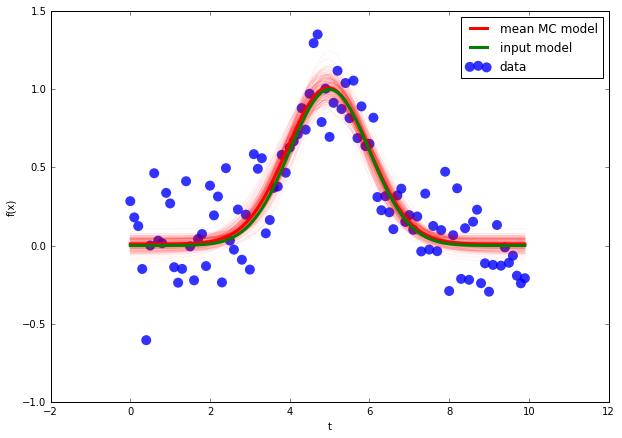

In [68]:
plotmodels(t,d,g,chain,mm,gaussian)

## 11. Triangle Plot of posteriors

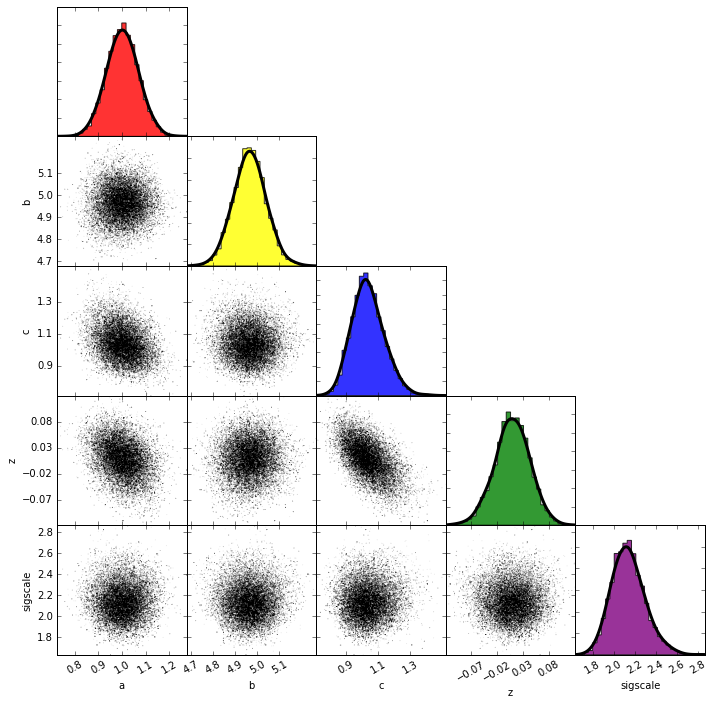

In [69]:
label=['a','b','c','z','sigscale']        # Labels for the plots
colour=['r','yellow','b','g','purple']  # Set colours
nbin=30                        # Number of bins for histogram
triplot(chain,burnin,label,colour,nbin,ntick=5)

# Other Topics?

priors - impact of priors  
annealing - methods for more efficient exploration of parameter space  
nested sampling - forget MCMC, nested sampling is better? (just ask the cosmologists)  

# IX. References

Ford, E. 2005 AJ 129, 1706  
Quantifying the Uncertainty in the Orbits of Extrasolar Planets  
http://adsabs.harvard.edu/abs/2005AJ....129.1706F  

Gregory, P. 2011 MNRAS, 410 94  
Bayesian exoplanet tests of a new method for MCMC sampling in highly correlated model parameter spaces  
http://adsabs.harvard.edu/abs/2011MNRAS.410...94G  

Balov, N.  
Gelman–Rubin convergence diagnostic using multiple chains  
http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/  
